In [1]:
import polars as pl
import seaborn as sb
import gtfs_delay_analysis as da

In [4]:
aggregated = da.load_aggregate_data()
stops = pl.read_parquet('data/stops.parquet')
raw_dfs = da.load_raw_data()

In [5]:
trips = da.trips.load_trips_without_shapes_df()
str_shapes = da.trips.load_str_shapes_df()
shapes = da.trips.load_parsed_shapes_df()
sequences = pl.read_parquet('stop-sequences.parquet')

In [6]:
all_004 =aggregated.join(trips, left_on='id', right_on='trip_id').filter(
    pl.col("shape_id").eq("004-171-East")
)

# Delay
# Derivative of delay

In [7]:
df = (
all_004.with_columns(pl.col('stopid').cast(pl.Utf8))
.join(
    sequences.with_columns(pl.col('stop_id').cast(pl.Utf8)),
    left_on=['id', 'stopid'],
    right_on=['trip_id', 'stop_id'],
)
.group_by('id', 'stopid', 'stop_sequence').agg(
    pl.col('meandelay').mean(),
)
.sort('id', 'stop_sequence')
)

specific_trip = df.filter(pl.col('id').eq(25536739))

In [8]:
def reorder_stops(df:pl.DataFrame, stop_id:str):
    stop_idx =df.filter(pl.col('stopid').eq(stop_id))['stop_sequence'][0]
    max_idx=df['stop_sequence'].max()
    df['stop_sequence'].max()
    return df.with_columns(
        pl.col('stop_sequence').sub(stop_idx).mod(max_idx)
    ).sort('stop_sequence')




In [9]:
def add_stops(df: pl.DataFrame):
    return (
        df
    .with_row_index()
        .with_columns(pl.col('line').str.split('-'))
    .with_columns(
        pl.col('line').list.get(0).alias('a'),
        pl.col('line').list.get(1).alias('b'),
    )
    .drop('line')
    .join(stops.select('stop_id', a_lon='stop_lon', a_lat='stop_lat'), left_on='a', right_on='stop_id')
    .join(stops.select('stop_id', b_lon='stop_lon', b_lat='stop_lat'), left_on='b', right_on='stop_id')
    .sort('index')
    .drop('index')
    )

In [10]:
from gtfs_delay_analysis.ddelay import get_ddelay,plot_ddelay

def ddelay_with_seq(d:pl.DataFrame):
    return (
        d.join(stops, left_on='stopid',right_on='stop_id')
        .with_columns( trip_id='id')
        .sort('stop_sequence')
        # .pipe(lambda d: display(d) or d)
        .with_row_index()
        .pipe(get_ddelay)
    )

def save(df:pl.DataFrame,name:str):
    import os
    write_path ='~/Downloads/GTFS'
    return df.write_csv(os.path.join(write_path, name))

def pre_process(df:pl.DataFrame):
    return df .pipe(ddelay_with_seq) .drop('trip_id') .pipe(add_stops) .with_row_index()

with_coords =(
df.group_by('stopid', 'stop_sequence')
.agg( pl.col('meandelay').mean())
.with_columns(id=0)
.pipe(reorder_stops, "2002")
.pipe(pre_process)
# .pipe(plot_ddelay)
# .pipe(save,'ddelay-all-4.csv')
)

# specific_trip.pipe(reorder_stops, "2002").pipe(ddelay_with_seq).pipe(save, 'ddelay-25536739.csv')
all_points = shapes.filter(pl.col('shape_id').eq('004-171-East')).explode('geometry_line').rename({
    'geometry_line':'points',
}).with_row_index()

# with_coords
points = all_points.select(
    'index','shape_id',
    lon=pl.col('points').struct.field('lon'),
    lat=pl.col('points').struct.field('lat'),
)


In [12]:
(df.group_by('stopid', 'stop_sequence')
.agg( pl.col('meandelay').mean())
.with_columns(id=0)
.pipe(reorder_stops, "2002")
).pipe(save, 'heading-stops.csv')

In [13]:
pp = points.with_columns(
    pl.col('index').sub(1).alias('prev')
).join(points,left_on='prev',right_on='index').select(
    index='prev',
    a_lon='lon',
    a_lat='lat',
    b_lon='lon_right',
    b_lat='lat_right',
)
with_coords.head(12).pipe(save, 'coords.csv')

In [14]:
str_shapes.filter(pl.col('shape_id').eq('004-171-East')).pipe(save ,'actual-shape.csv')

In [15]:
specific_trip.join(stops, left_on='stopid',right_on='stop_id').sort('stop_sequence').with_columns(
    trip_id='id'
).with_row_index()

index,id,stopid,stop_sequence,meandelay,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,geometry_point,trip_id
u32,i64,str,i8,f64,str,str,str,f64,f64,str,str,i64,str,str,i64
0,25536739,"""8602""",1,123.014384,"""8602""","""Lewis Farms Tr…",null,53.523196,-113.666821,"""1EDM""",null,0,null,"""POINT (-113.66…",25536739
1,25536739,"""5783""",2,437.673968,"""5783""","""187 Street & 8…",null,53.521312,-113.646668,"""1EDM""",null,0,null,"""POINT (-113.64…",25536739
2,25536739,"""5820""",3,418.604882,"""5820""","""186 Street & 8…",null,53.52138,-113.643161,"""1EDM""",null,0,null,"""POINT (-113.64…",25536739
3,25536739,"""5737""",4,433.124015,"""5737""","""182 Street & 8…",null,53.521484,-113.639395,"""1EDM""",null,0,null,"""POINT (-113.63…",25536739
4,25536739,"""5654""",5,422.573933,"""5654""","""182 Street & 8…",null,53.521506,-113.636575,"""1EDM""",null,0,null,"""POINT (-113.63…",25536739
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
34,25536739,"""2328""",56,882.0,"""2328""","""79 Street & 82…",null,53.517977,-113.44847,"""1EDM""",null,0,null,"""POINT (-113.44…",25536739
35,25536739,"""2260""",57,984.0,"""2260""","""75 Street & 83…",null,53.518835,-113.442755,"""1EDM""",null,0,null,"""POINT (-113.44…",25536739
36,25536739,"""2361""",58,954.0,"""2361""","""75 Street & 84…",null,53.520337,-113.442767,"""1EDM""",null,0,null,"""POINT (-113.44…",25536739


In [16]:
shapes.filter(pl.col('shape_id').str.starts_with('004-171').or_(
pl.col('shape_id').str.starts_with('004-172')
)).explode('geometry_line').select(
    'shape_id',
    lon=pl.col('geometry_line').struct.field('lon'),
    lat=pl.col('geometry_line').struct.field('lat'),
).write_csv('~/Downloads/GTFS/004-East-shapes.csv')

In [17]:
from geopy.distance import geodesic

In [18]:
def calculate_slope(df:pl.DataFrame):
    return df.with_columns(
        pl.struct(
            lon1='a_lon',
            lat1='a_lat',
            lon2='b_lon',
            lat2='b_lat',
        ).map_elements(lambda x: geodesic((x['lat1'], x['lon1']), (x['lat2'], x['lon2'])).km).alias('distance')
    ).with_columns(pl.col('ddelay').truediv('distance').alias('slope'))

# with_coords.head(12).pipe(calculate_slope).pipe(save,'heading-slope.csv')
specific_trip.pipe(reorder_stops, "2002").pipe(save,'specific-stops.csv')
# .pipe(pre_process).head(12).pipe(calculate_slope).pipe(save,'specific-trip-slope.csv')

In [19]:
import seaborn as sb

In [20]:
from io import StringIO
df = pl.read_csv(StringIO("""distance,meandelay,ddelay
0.260948712,780,-132
0.49200577,648,123
0.762336063,771,-107
1.105268809,664,86
1.36051648,750,9
1.696549156,759,-58.5
2.516094026,700.5,122.8333333
2.685788091,823.3333333,-6.666666667
3.067528361,816.6666667,26.66666667
3.451850377,843.3333333,-71.66666667
3.671237928,771.6666667,31.66666667
4.095030012,803.3333333,36.66666667"""))

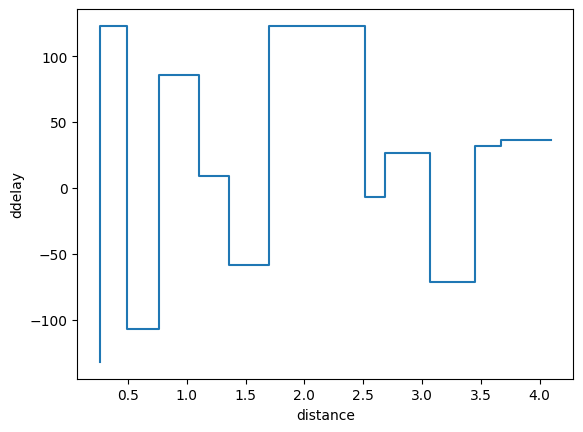

In [21]:
ax =sb.lineplot(df, x='distance', y='ddelay',drawstyle='steps-pre')

In [22]:
df

distance,meandelay,ddelay
f64,f64,f64
0.260949,780.0,-132.0
0.492006,648.0,123.0
0.762336,771.0,-107.0
1.105269,664.0,86.0
1.360516,750.0,9.0
…,…,…
2.685788,823.333333,-6.666667
3.067528,816.666667,26.666667
3.45185,843.333333,-71.666667
